# CAPSTONE PROJECT -  Pneumonia Detection System

<b>The Real Problem : </b>  
- What is Pneumonia?  
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post- radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis. CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
  
- Pneumonia Detectiontion  
Now to detect Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

- Business Domain Value  
Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

<b>Project Description</b>  
- In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.   
Details about the data and dataset files are given in below link :-  
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### 1. Pre-Processing, Data Visualization, EDA :-
- Exploring the given Data files, classes and images of different classes.
- Dealing with missing values
- Visualization of differentclasses
- Analysis from the visualization of different classes.

<b>Install libraries required</b>

In [ ]:
# Required to open dcm images
!pip install pydicom

<b>Import necesaary modules</b>

In [ ]:
import os
import pandas as pd
import numpy as np
#from google.colab import drive
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tqdm
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
from shutil import copyfile, rmtree
import random

In [ ]:
seed = 7
np.random.seed(seed)

<b>Mount google drive at '/mnt'</b>

In [ ]:
#drive.mount('/mnt')

<b>Below steps are required to download dataset from kaggle</b>

In [ ]:
#!mkdir /root/.kaggle
#!cp /mnt/MyDrive/Dataset/kaggle.json /root/.kaggle/

In [ ]:
!cp -r /kaggle/input/rsna-pneumonia-detection-challenge/ /kaggle/working/

In [ ]:
DATASET_BASE_DIR = '/kaggle/working/rsna-pneumonia-detection-challenge/'

In [ ]:
os.chdir(DATASET_BASE_DIR)

<b>Download dataset from kaggle</b>

In [ ]:
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [ ]:
#!ls

In [ ]:
#!unzip -q rsna-pneumonia-detection-challenge.zip

In [ ]:
!ls

- There are six files in the dataset.  
- Files 'stage_2_train_labels.csv', 'stage_2_detailed_class_info.csv' and directory 'stage_2_train_images' are of our interest. Rest all can be ignored.

<b>Read stage_2_train_labels.csv</b>

In [ ]:
train_labels = pd.read_csv('./stage_2_train_labels.csv')

In [ ]:
print(f'Dataframe Shape : {train_labels.shape}')

In [ ]:
train_labels.info()

- 'Target' specifies whether the patient has pneumonia or not.
- x,y, width and height must be the location of pneumonia patches in x-ray.
- There are null entries in the x, y, width and height columns.

In [ ]:
train_labels.head(10)

In [ ]:
train_labels.sample(5)

- It seems that x, y, width and height are null whereever 'Target' is 0 which makes sense since there should be no patches if the patient doesn't have pneumonia. Thus we can safely keep x, y, width and height 0 for null entries.

In [ ]:
train_labels['x'] = train_labels['x'].fillna(0)
train_labels['y'] = train_labels['y'].fillna(0)
train_labels['width'] = train_labels['width'].fillna(0)
train_labels['height'] = train_labels['height'].fillna(0)

<b>Load 'stage_2_detailed_class_info.csv'</b>

In [ ]:
class_info = pd.read_csv('./stage_2_detailed_class_info.csv')

In [ ]:
print(f'Dataframe Shape : {class_info.shape}')

In [ ]:
class_info.info()

In [ ]:
class_info.head(5)

In [ ]:
class_info.sample(5)

- 'stage_2_detailed_class_info.csv' specifies the exact class of each patient, i.e., 'Normal', 'Lung Opacity' and 'No Lung Opacity, Not Normal.
- There are no null values in this dataframe.

<b>Let's concatenate the two dataframes and use the merged dataframe for further analysis.</b>

In [ ]:
df = pd.concat([train_labels, class_info['class']], axis = 1)

<b>Checking shape and info of merged dataframe</b>

In [ ]:
print(f'Dataframe shape : {df.shape}')

In [ ]:
df.info()

<b>Unique Patient Ids</b>

In [ ]:
print('Number of unique Patient Ids :', train_labels['patientId'].unique().shape[0])

- Number of unique patients is different than the number of rows in the dataset. 

To find out the reason, let's take a look at the any one patient that has multiple rows.

In [ ]:
df[df['patientId'] == df[df['patientId'].duplicated()]['patientId'].values[0]]

- The reason of duplicate patientIds is due to the fact that a patient can have multiple pneumonia patches in xray. So we'll keep all the duplicate entries.

In [ ]:
def countplot_with_percentage(clm, name = None, xlabel = None):
  ''' Function to plot a countplot with percentage for each category'''
  plt.figure(figsize = (10, 5));
  ax = sns.countplot(x = clm);
  total = len(clm)
  for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + (p.get_width()/2)
            y = p.get_y() + p.get_height() + 1
            ax.annotate(percentage, (x,y), horizontalalignment='center');
  if(name != None):
    plt.title(f'Countplot - {name}')
  if (xlabel != None):
    plt.xlabel(xlabel)
  plt.show();

<b>Number of pneumonia patches per patient</b>

In [ ]:
df[df['Target'] == 1]['patientId'].value_counts().value_counts()

In [ ]:
countplot_with_percentage(df[df['Target'] == 1]['patientId'].value_counts().reset_index()['patientId'], 'No. of Patches', 'Patches per Patient')

- 98% of the patients who have pneumonia have 1 or 2 patches.

<b>Target distribution</b>

Before visualizing target distribution, we'll group the dataframe by patientId to make sure we get the correct target distribution.

In [ ]:
df_grouped = df.groupby('patientId')

In [ ]:
df_grouped['Target'].aggregate('first').value_counts()

In [ ]:
countplot_with_percentage(df_grouped['Target'].aggregate('first'), 'Target')

- Dataset is highly imbalanced with respect to 'Target' column.
- Only 22.5% of patients in dataset have pneumonia.

<b>Class Distribution</b>

In [ ]:
df_grouped['class'].aggregate('first').value_counts()

In [ ]:
countplot_with_percentage(df_grouped['class'].aggregate('first'), 'Class')

- 44% of the records in dataset do not have lung opacity but still X-ray is not normal.

<b>Exploring the dcm files</b>

As mentioned in the project description, the image files have .dcm extension.  
The DCM file extension is used for DICOM which stands for Digital Imaging and Communications in Medicine. This is the common file format used to store medical imaging data when a patient undergoes a CT, MRI, PET, UltraSound, and many other types of medical scans. They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

In [ ]:
TRAIN_IMAGES_BASE_PATH = os.path.join(DATASET_BASE_DIR,'stage_2_train_images/')

Listing first ten files from 'stage_2_train_images' directory

In [ ]:
os.listdir(TRAIN_IMAGES_BASE_PATH)[0:10]

The filenames in the images directory correspond to the pateintIds. The same patientIds must exist in dataset as well.

Let's open any one file and see how it looks. pydicom is the python library that undertands the .dcm file format. We have already installed it in the beginning of notebook.

In [ ]:
# Patient with normal X-ray
dcm_img_file = pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, '984afed3-af7c-45d3-b202-4788f9522b28.dcm'))

In [ ]:
type(dcm_img_file)

In [ ]:
dcm_img_file

- The dcm file contains metadata related to file format(version,UIDs, etc.), patient(patientId, Gender, Age, etc.), examination(View position, Body part examined, etc.), pixel data(rows, columns, compression method, etc.)
- 'Pixel Data' contains the actual image
- This particular dcm file contains grayscale image(Photometric Interpretation -'MONOCHROME2')
- We can use the metadata like 'Patient's Sex', 'Patient's Age', 'View Position' to understand the data further.

Before that, let's visualize the Pixel Data in the above image.

In [ ]:
img = dcm_img_file.pixel_array

In [ ]:
print(f'Image shape : {img.shape}')

So, it's a grayscale image of resolution 1024x1024.

In [ ]:
plt.figure(figsize = (8,8));
plt.imshow(img, cmap = plt.cm.gray);
plt.title(dcm_img_file.PatientID);
plt.show();

Let's plot x-rays of patients whose:-
- X-ray class is 'Normal'
- X-ray class is 'Lung Opacity'
- X-ray class is 'No Lung Opacity / Not Normal'

In [ ]:
classes = df['class'].unique()
fig, ax = plt.subplots(len(classes), 4, figsize = (24, 24))
for i, cls in enumerate(classes):
  for j in range(4):
    id = df[df['class'] == cls]['patientId'].values[np.random.randint(100)]
    img_file = pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, id + '.dcm'))
    img = img_file.pixel_array
    age = img_file.PatientAge
    gender = img_file.PatientSex
    ax[i,j].imshow(img, cmap = plt.cm.gray);
    ax[i,j].set_title(id + f'\n({age}/{gender}/{cls})');
plt.show();

<b>Let's plot the x-ray of patient having pneumonia with the corresponding patches</b>

In [ ]:
def rsna_get_xray(id):
  '''
  Function to return x-ray pixel data
  Inputs : 
          id - Patient ID
  '''
  return pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, id)+'.dcm').pixel_array

In [ ]:
def rsna_get_xray_with_bboxes(id):
  '''
  Function to return xray with bounding boxes
  Inputs : 
          id - Patient ID
  '''
  img = rsna_get_xray(id)
  rec = df[df['patientId'] == id]
  if(rec.shape[0] == 0):
    return img
  for i, row in rec.iterrows():
    if(row['Target'] == 0):
      continue;
    img = cv2.rectangle(img, (int(row['x']), int(row['y'])), (int(row['x']) + int(row['width']), int(row['y']) + int(row['height'])), 0, 3)
  return img

In [ ]:
plt.figure(figsize = (8,8))
id = df.loc[np.random.choice(df[df['Target'] == 1].index)]['patientId']
plt.imshow(rsna_get_xray_with_bboxes(id), cmap = plt.cm.gray);
plt.title(id);
plt.show();

<b>Read each dcm file in 'stage_2_train_images' and store metadata in dataframe</b>

In [ ]:
for filename in os.listdir(TRAIN_IMAGES_BASE_PATH):
  with pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, filename)) as img:
    id = img.PatientID
    age = img.PatientAge
    gender = img.PatientSex
    vp = img.ViewPosition
    ncols = img.Columns
    nrows = img.Rows

    # Check if patientId exists in dataframe
    indices = df[df['patientId'] == id].index
    if(indices.shape[0] != 0):
      df.loc[indices, 'Age'] = age
      df.loc[indices, 'Gender'] = gender
      df.loc[indices, 'View_Position'] = vp
      df.loc[indices, 'Image_Height'] = nrows
      df.loc[indices, 'Image_Width'] = ncols

Check how the final dataset looks like

In [ ]:
df.info()

In [ ]:
df.sample(5)

- We have added five new columns to dataset - Age, Gender, View Position, Image height and Image Width.
- Image Height and Image Width have been added just to check if all images are of same resolution. 

Convert the datatypes of some of the columns before we use them further.

In [ ]:
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
df['width'] = df['width'].astype('int')
df['height'] = df['height'].astype('int')
df['Image_Width'] = df['Image_Width'].astype('int')
df['Image_Height'] = df['Image_Height'].astype('int')
df['Age'] = df['Age'].astype('int')

Regroup the dataframe by 'patientId'

In [ ]:
df_grouped = df.groupby('patientId')

Analyzing "View Position" Column

In [ ]:
view_positions = df_grouped['View_Position'].aggregate('first')

In [ ]:
view_positions.value_counts()

There are two different View Positions in dataset :-
- PA (Posterior-Anterior)
- AP (Anterior-Posterior)  

PA radiographs are taken while the patient faces away from the X-ray tube. X-rays enter from their Posterior and comes out of their Anterior.  

AP radiographs are taken with the patient facing the X-ray tube, so that x-ray beams enter their Anterior and exits from Posterior.

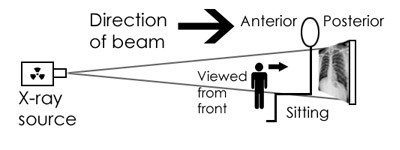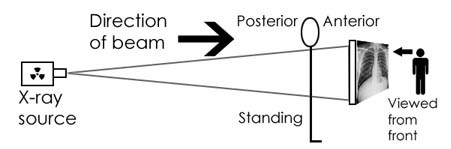

References :-
- https://chiro.org/radiology/ABSTRACTS/procedures.pdf
- https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection

In [ ]:
countplot_with_percentage(view_positions, 'View Position')

- PA position X-ray counts are slightly higher than the AP position X-rays in dataset.

In [ ]:
target = df_grouped['Target'].aggregate('first')

In [ ]:
plt.figure(figsize = (8,8));
sns.countplot(x = view_positions, hue = target);
plt.title('Target by View Position');
plt.show();

- X-rays taken in AP view have more pneumonia cases than those taken in PA position.

Analyzing "Gender" Column

In [ ]:
gender = df_grouped['Gender'].aggregate('first')

In [ ]:
gender.value_counts()

In [ ]:
countplot_with_percentage(gender, 'Gender')

- 57% of the patients are Male in dataset.

Target distribution by Gender

In [ ]:
target = df_grouped['Target'].aggregate('first')

In [ ]:
plt.figure(figsize = (8,8));
sns.countplot(x = target, hue = gender);
plt.title('Gender Distribution by Target');
plt.show();

Analyzing "Age" column

In [ ]:
age = df_grouped['Age'].aggregate('first')

In [ ]:
age.describe()

In [ ]:
plt.figure(figsize = (6,8));
sns.boxplot(y = age);
plt.title('Boxplot - Age');
plt.show();

In [ ]:
plt.figure(figsize = (20,6));
sns.histplot(age, kde = True);
plt.title('Age Distribution');
plt.show();

- Mean age is 49 years in dataset.
- 75% of the patients are less than 59 years.
- There are certain patients whose age is above 140 years. Most likely these are incorrect records in the dataset.

In [ ]:
fig = plt.figure(figsize = (8, 6));
sns.boxplot(y = age, x = target);
plt.title('Age Distribution by Target');
plt.show();

- Age distribution is similar for normal patients and patients with pneumonia. 


Check if all images are of same resolution

In [ ]:
print('Number of unique values in Image Height : ',df['Image_Height'].unique())
print('Number of unique values in Image Width : ',df['Image_Width'].unique())

All Images are of same resolution.

### Data Prepration and pre-processing

To be able to use data in model building, we will first split the data into train, test and validation. Then we would store the images in png format so that we can use images in model building via ImageGenerators( and apply augmentation as well).

<b>Split data into train, test and validation sets</b>

Prepare dataframe of unique patients and corresponding target

In [ ]:
#TRAIN_IMAGES_BASE_PATH = os.path.join(DATASET_BASE_DIR,'stage_2_train_images')
#df = pd.read_csv('/mnt/MyDrive/Dataset/df_final.csv')
#df_grouped = df.groupby('patientId')

<b>Remove this before final submission</b>

In [ ]:
df_unique = df_grouped['Target'].aggregate('first').reset_index()

In [ ]:
X = df_unique['patientId']
y = df_unique['Target']

In [ ]:
print(f'Number of unique patients : {X.shape[0]}')

Split the patientIds into train, test and validation sets. Make sure that all three sets have the same proportion of target.

In [ ]:
patientids_train, patientids_test, y_train_ignore, y_test_ignore = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 33)

In [ ]:
patientids_val, patientids_test, y_val_ignore, y_test_ignore = train_test_split(patientids_test, y_test_ignore, test_size = 0.5, stratify = y_test_ignore, random_state = 33)

Verify if all three sets have same proportion of 'Target'

In [ ]:
y_train_ignore.value_counts(normalize=True)

In [ ]:
y_val_ignore.value_counts(normalize=True)

In [ ]:
y_test_ignore.value_counts(normalize=True)

Store X-rays directory corresponding to the set(train, test and validation).  
The directory structure would look like :  
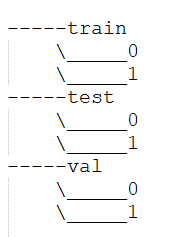

In [ ]:
top_dirs = ['train', 'test','val']

In [ ]:
os.chdir(DATASET_BASE_DIR)
for main_dir in top_dirs:
  os.mkdir(main_dir)
  os.chdir(main_dir)
  os.mkdir('0')
  os.mkdir('1')    

  if main_dir == 'train':
    ids = patientids_train
  elif main_dir == 'val':
    ids = patientids_val
  else:
    ids = patientids_test

  for patient_id in tqdm.tqdm(ids):
      # Open pydicom file
      img = pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, patient_id)+'.dcm').pixel_array

      if (df_unique[df_unique['patientId'] == patient_id]['Target'].values == 0):
        parent_dir = '0'
      else:
        parent_dir = '1'

      # Save pixel_array to png file
      cv2.imwrite(os.path.join(parent_dir, patient_id+'.png'), img)

  os.chdir('..')

Configurations :-

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128

Create an ImageDataGenerator object with data augmentation for training data

In [ ]:
datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.05, 
                                   height_shift_range=0.05, shear_range=0.05, 
                                   zoom_range=0.05, horizontal_flip = True, 
                                   fill_mode='nearest')

Create a directory iterator with batch size of 1 just to test how the generated images would look like

In [ ]:
myGenerator = datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR,'train'), 
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=1)

In [ ]:
def show_generator_images(tgt):
  '''
  Function to visualize the images generated by directory iterator
  (with augmentation) corresponding to the provided target.
  '''
  counter = 0
  fig, ax = plt.subplots(1, 6, figsize = (20, 6))
  for i in range(len(patientids_train)):
    img, target = myGenerator.__next__()
    if(int(target[0]) != tgt):
      continue
    ax[counter].imshow(np.squeeze(img[0]), cmap=plt.cm.gray);
    counter = counter + 1
    if(counter >= 6):
      break
  plt.title(int(target[0]))
  plt.show();

Sample images generated for target 0

In [ ]:
show_generator_images(0)

Sample images generated for target 1

In [ ]:
show_generator_images(1)

Creating the train, test and validation iterators that will be in model building

In [ ]:
train_generator = datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR,'train'), 
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

Create a seperate generator(and directory iterators) for validation and test data.

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'test'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE,
                                          shuffle = False)
val_generator = test_datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'val'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

### Model Building

We will start with a basic CNN model that will predict the target. In the final submission we will focus on predicting the pneumonia patches.

In [ ]:
def simple_cnn_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
  
  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(activation = 'relu', units = 256,  kernel_initializer=tf.keras.initializers.he_normal(seed)))
  #model.add(Dense(activation = 'relu', units = 64,  kernel_initializer=initializers.he_normal(seed)))

  model.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

  return model

In [ ]:
model = simple_cnn_model()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 1e-08)

In [ ]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
'''model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(activation = 'relu', units = 256,  kernel_initializer=tf.keras.initializers.he_normal(seed)))
#model.add(Dense(activation = 'relu', units = 64,  kernel_initializer=initializers.he_normal(seed)))
model.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 1e-08)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])'''

In [ ]:
model.summary()

Create a checkpoint to save the best model

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATASET_BASE_DIR,'rsna_simple_predict.h5'), save_best_only = True, 
                                                      monitor = 'val_accuracy', mode='max', verbose = 1)

In [ ]:
history = model.fit(train_generator, epochs = 10, validation_data = val_generator, batch_size = BATCH_SIZE, callbacks = [model_checkpoint])

We are getting best accuracy of approximately 81% on validation dataset.

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Loss on training data')
  plt.plot(history.history['val_loss'], label='Loss on validation data')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch')
  plt.legend()
  plt.grid(True)
  plt.show();

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='Accuracy on training data')
  plt.plot(history.history['val_accuracy'], label='Accuracy on validation data')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Epoch')
  plt.legend()
  plt.grid(True)
  plt.show();

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

Load the best model and check accuracy on test data

In [ ]:
best_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_simple_predict.h5'))

In [ ]:
score = best_model.evaluate(test_generator)

In [ ]:
print(f'Best model has accuracy : {round(score[1]*100, 2)}% and loss : {round(score[0], 2)} on test data')

In [ ]:
y_test_predict = best_model.predict(test_generator)

In [ ]:
print(f'Confusion Matrix(Test Data)')
df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_test_predict > 0.5))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
display(df_cm)

In [ ]:
print(classification_report(test_generator.classes, y_test_predict > 0.5))

We are getting a decent accuracy of approximately 81% on test data. 
F-1 Score for class 0 is 88% while for class 1 it is 51% which is quite low.

Storing some of the metrics and model-related information in table that can be used later for performance comparison. The table shall contain:-
- Model Name (For identifying the approach used)
- Accuracy on training dataset
- Accuracy on test dataset
- 'Pneumonia Positive' class F1-score
- 'Pneumonia Positive' class recall
- 'Pneumonia Positive' class precision
- Trained on undersampled dataset?
- Class Threshold

In [ ]:
models_table = []

In [ ]:
models_table.append({'Name' : 'Simple CNN', 
                     'Train_Accuracy' : round(best_model.evaluate(train_generator)[1]*100, 2), 
                     'Test_Accuracy' : round(score[1]*100, 2),
                     'Class_1_F1_Score' : f1_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Recall' : recall_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Precision' : precision_score(test_generator.classes, y_test_predict > 0.5),
                     'UnderSampling_Used' : 0,
                     })

Next we will train the same model on undersampled data to see if data balancing has any effect

In [ ]:
# Init RandomUnderSampler
rand_unsampler = RandomUnderSampler(random_state = 33)

In [ ]:
rand_unsampler = rand_unsampler.fit(np.array(patientids_train.to_list()).reshape(-1, 1), y_train_ignore)

In [ ]:
patientids_train_rus, y_train_ignore_rus = rand_unsampler.fit_resample(np.array(patientids_train.to_list()).reshape(-1, 1), y_train_ignore)

Check proportion of the two classes in undersampled dataset

In [ ]:
y_train_ignore_rus.value_counts(normalize=True)

Create a seperate directory for undersampled training set

In [ ]:
os.chdir(DATASET_BASE_DIR)
os.mkdir('train_undersampled')
os.chdir('train_undersampled')
os.mkdir('0')
os.mkdir('1')

for patient_id in tqdm.tqdm(patientids_train_rus.squeeze()):
  # Open pydicom file
  img = pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, patient_id)+'.dcm').pixel_array
  
  if (df_unique[df_unique['patientId'] == patient_id]['Target'].values == 0):
    parent_dir = '0'
  else:
    parent_dir = '1'
  
  # Save pixel_array to png file
  cv2.imwrite(os.path.join(parent_dir, patient_id+'.png'), img)

Create a generator for the undersampled training set

In [ ]:
train_generator_undersampled = datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'train_undersampled'), 
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

Init simple CNN model

In [ ]:
model = simple_cnn_model()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 1e-08)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

Create Checkpoint

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATASET_BASE_DIR,'rsna_simple_predict_rus.h5'), save_best_only = True, 
                                                      monitor = 'val_accuracy', mode='max', verbose = 1)

In [ ]:
history = model.fit(train_generator_undersampled, epochs = 10, validation_data = val_generator, batch_size = BATCH_SIZE, callbacks = [model_checkpoint])

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

Load the best model and check accuracy on test data

In [ ]:
best_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_simple_predict_rus.h5'))

In [ ]:
score = best_model.evaluate(test_generator)

In [ ]:
print(f'Best model has accuracy : {round(score[1]*100, 2)}% and loss : {round(score[0], 2)} on test data')

In [ ]:
y_test_predict = best_model.predict(test_generator)

In [ ]:
print(f'Confusion Matrix(Test Data)')
df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_test_predict > 0.5))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
display(df_cm)

In [ ]:
print(classification_report(test_generator.classes, y_test_predict > 0.5))

Although the model accuracy has reduced but we are seeing good improvement in pneumonia class recall. Recall is what we believe is important for this problem because we may not want to let any pneumonia patient go undetected even if False positives increase slightly.

In [ ]:
models_table.append({'Name' : 'Simple CNN', 
                     'Train_Accuracy' : round(best_model.evaluate(train_generator_undersampled)[1]*100, 2), 
                     'Test_Accuracy' : round(score[1]*100, 2),
                     'Class_1_F1_Score' : f1_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Recall' : recall_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Precision' : precision_score(test_generator.classes, y_test_predict > 0.5),
                     'UnderSampling_Used' : 1,
                     })

Next we will use Transfer Learning with following CNN archtectures :-
  1. Resnet-50
  2. VGG16
  3. Mobilenet

Create Generators to be used

In [ ]:
train_generator = datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'train'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

train_generator_undersampled = datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'train_undersampled'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'test'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE,
                                          shuffle = False)

val_generator = test_datagen.flow_from_directory(os.path.join(DATASET_BASE_DIR, 'val'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)

Function to create Resnet-50 model



In [ ]:
def resnet_50_model():
  backend = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

  # Set this parameter to make sure it's not being trained
  backend.trainable = False

  # Set the input layer
  input_ = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # Set the backend layer
  x = backend(input_, training=False)

  # Set the pooling layer
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # Set the final layer with sigmoid activation function
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create the new model object
  model = tf.keras.Model(input_, output_)

  return model

Function to create VGG16 model

In [ ]:
def vgg16_model():
  backend = tf.keras.applications.VGG16(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

  backend.trainable = False

  # Set the input layer
  input_ = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # Set the feature extractor layer
  x = backend(input_, training=False)

  # Set the pooling layer
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # Set the final layer with sigmoid activation function
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create the new model object
  model = tf.keras.Model(input_, output_)

  return model

Function to create Mobilenet model

In [ ]:
def mobilenet_model():
  feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights="imagenet", include_top=False, alpha=0.35)

  # Set this parameter to make sure it's not being trained
  feature_extractor.trainable = False

  # Set the input layer
  input_ = tf.keras.Input(shape=(224, 224, 3))

  # Set the feature extractor layer
  x = feature_extractor(input_, training=False)

  # Set the pooling layer
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  output = tf.keras.layers.BatchNormalization()(x)
  output_ = tf.keras.layers.Dense(256, activation='relu')(x)
  output = tf.keras.layers.BatchNormalization()(x)
  output_ = tf.keras.layers.Dense(128, activation='relu')(x)
  output = tf.keras.layers.BatchNormalization()(x)

  # Set the final layer with sigmoid activation function
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create the new model object
  model = tf.keras.Model(input_, output_)

  return model

Train all models in a loop

In [ ]:
models_input = [
                {'name' : 'Resnet-50', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_resnet.h5'), 'undersample' : 0, 'epochs' : 10},
                {'name' : 'Resnet-50', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_resnet_undersampled.h5'), 'undersample' : 1, 'epochs' : 10},
                {'name' : 'VGG16', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_vgg16.h5'), 'undersample' : 0, 'epochs' : 10},
                {'name' : 'VGG16', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_vgg16_undersampled.h5'), 'undersample' : 1, 'epochs' : 10},
                {'name' : 'Mobilenet', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_mobilenet.h5'), 'undersample' : 0, 'epochs' : 10},
                {'name' : 'Mobilenet', 'ckpt_name' : os.path.join(DATASET_BASE_DIR,'rsna_predict_mobilenet_undersampled.h5'), 'undersample' : 1, 'epochs' : 10},
]

num_models = len(models_input)

In [ ]:
for model_entry in models_input:
  print('\n\n*************************************************************************************************************************')
  print('Training model ', model_entry['name'], 'with undersampling', 'enabled' if model_entry['undersample'] == 1 else 'disabled')
  print('*************************************************************************************************************************')

  # Create model
  if model_entry['name'] == 'Resnet-50':
    model = resnet_50_model()
  elif model_entry['name'] == 'VGG16':
    model = vgg16_model()
  elif model_entry['name'] == 'Mobilenet':
    model = mobilenet_model()
  else:
    print('Unsupported model : ', model_entry['name'])

  # Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Show model summary
  model.summary()

  # Create Checkpoint
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_entry['ckpt_name'], save_best_only = True, 
                                                      monitor = 'val_accuracy', mode='max', verbose = 1)
  
  # Train model
  history = model.fit(train_generator_undersampled if model_entry['undersample'] == 1 else train_generator, 
                      epochs = model_entry['epochs'], validation_data = val_generator, batch_size = BATCH_SIZE, callbacks = [model_checkpoint])
  
  # Load the best model
  best_model = tf.keras.models.load_model(model_entry['ckpt_name'])

  # Evaluate on test data
  score = best_model.evaluate(test_generator)
  print(f'Best model has accuracy : {round(score[1]*100, 2)}% and loss : {round(score[0], 2)} on test data')

  # Confusion Matrix and Classification report
  y_test_predict = best_model.predict(test_generator)

  # Use default threshold for now
  print(f'Confusion Matrix(Test Data)')
  df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_test_predict > 0.5))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  display(df_cm)

  print(classification_report(test_generator.classes, y_test_predict > 0.5))

  # Append the results in models_data_table list
  models_table.append({'Name' : model_entry['name'], 
                     'Train_Accuracy' : round(best_model.evaluate(train_generator_undersampled if model_entry['undersample'] == 1 else train_generator)[1]*100, 2), 
                     'Test_Accuracy' : round(score[1]*100, 2),
                     'Class_1_F1_Score' : f1_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Recall' : recall_score(test_generator.classes, y_test_predict > 0.5),
                     'Class_1_Precision' : precision_score(test_generator.classes, y_test_predict > 0.5),
                     'UnderSampling_Used' : model_entry['undersample'],
                     })

In [ ]:
pd.DataFrame(models_table)

Of all the models and techniques we tried, VGG16 trained on undersampled dataset has good overall performance(considering accuracy, recall and F1-score). Although recall of mobilenet is highest but overall performance of VGG16 seems pretty good.

Next, we'll see if we can tweak threshold a bit to get better results on test dataset. For this we will load the best performing model from the above table.

In [ ]:
#!ls ./rsna-pneumonia-detection-challenge/train_undersampled

In [ ]:
#!ls

In [ ]:
#from IPython.display import FileLink
#os.chdir('/kaggle/working')
#FileLink(r'./rsna-pneumonia-detection-challenge/train_undersampled/rsna_simple_predict_rus.h5')
#os.chdir('/kaggle/working/rsna-pneumonia-detection-challenge/train_undersampled/')

In [ ]:
best_model_chkp_name = os.path.join(DATASET_BASE_DIR, 'rsna_predict_mobilenet_undersampled.h5')

Load best model

In [ ]:
best_model = tf.keras.models.load_model(best_model_chkp_name)

Predict on test dataset

In [ ]:
y_test_predict = best_model.predict(test_generator)

Check classification report with probabilities of 0.45, 0.4, 0.35, 0.3

In [ ]:
probabilities = [0.45, 0.4, 0.35, 0.3]

In [ ]:
for p in probabilities:
    print('*********************************************')
    print(f'Classification report with probability = {p}')
    print('*********************************************')
    print(classification_report(test_generator.classes, y_test_predict > p))

The probability 0.35 seems to have decent metrics. We'll use 0.35 as threshold for the final model.

<b>Predicting Pneumonia Patches</b>

So far we have worked on classifying the patients. Next, we'll work on predicting the pneumonia patches of the pneumonia patients and finally we'll integrate the two models(one for classification and other for patches prediction).


Before we build unet model, we'll need to prepare data for training and testing model. For training and validating u-net model, we need images and corresponding masks that have the pneumonia patches. This is how the directory structure would look like :-  
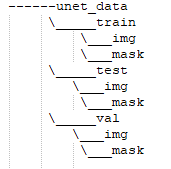

In [ ]:
# Freeing up some space
rmtree(os.path.join(DATASET_BASE_DIR, 'train', '0'))
rmtree(os.path.join(DATASET_BASE_DIR, 'val', '0'))
rmtree(os.path.join(DATASET_BASE_DIR, 'stage_2_test_images'))

In [ ]:
# Location to store images and mask
UNET_DATA_DIR = os.path.join(DATASET_BASE_DIR, 'unet_data')

In [ ]:
os.mkdir(UNET_DATA_DIR)
os.chdir(UNET_DATA_DIR)
sub_dir = ['train', 'test', 'val']

In [ ]:
for dir in sub_dir:
  os.mkdir(dir)
  os.chdir(dir)
  os.mkdir('img')
  os.mkdir('mask')

  if dir == 'train':
    ids = patientids_train
  elif dir == 'val':
    ids = patientids_val
  else:
    ids = patientids_test

  for patient_id in tqdm.tqdm(ids):

    rec = df[df['patientId'] == patient_id]

    mask = np.zeros((1024, 1024))

    for j, row in rec.iterrows():
      if(row['Target'] == 0):
        continue;

      xmin = int(df.loc[j,'x'])
      ymin = int(df.loc[j,'y'])
      xmax = xmin + int(df.loc[j,'width'])
      ymax = ymin + int(df.loc[j,'height'])
      mask[ymin:ymax, xmin:xmax] = 255

      copyfile(os.path.join(DATASET_BASE_DIR, dir, '1', patient_id) +'.png', os.path.join(UNET_DATA_DIR, dir, 'img', patient_id) +'.png')

      # Save masks as png
      cv2.imwrite(os.path.join(UNET_DATA_DIR, dir, 'mask', patient_id) +'.png', mask)

  os.chdir('..')

Defining a function that returns the generator object usable by u-net model. It essentialy returns augmented(if enabled) image and corresponding mask.

In [ ]:
def unetGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale", num_class = 2, target_size = (IMG_HEIGHT, IMG_WIDTH), seed = 33):
  '''
  NOTE : Use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
  '''
  image_datagen = ImageDataGenerator(**aug_dict)

  mask_datagen = ImageDataGenerator(**aug_dict)

  image_generator = image_datagen.flow_from_directory(train_path,
                                                      classes = [image_folder],
                                                      class_mode = None,
                                                      color_mode = image_color_mode,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      seed = seed)

  mask_generator = mask_datagen.flow_from_directory(train_path,
                                                    classes = [mask_folder],
                                                    class_mode = None,
                                                    color_mode = mask_color_mode,
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    seed = seed)

  combined_generator = zip(image_generator, mask_generator)
  for (img,mask) in combined_generator:
    # Normalize image and mask
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    yield (img,mask)

Visualizing the image and mask returned by the generator

In [ ]:
data_gen_args = dict(rotation_range=0.2, width_shift_range=0.05, 
                     height_shift_range=0.05, shear_range=0.05, 
                     zoom_range=0.05, horizontal_flip=True, 
                     fill_mode='nearest')

In [ ]:
dummyGenerator = unetGenerator(1, os.path.join(UNET_DATA_DIR, 'train'),
                             'img','mask', data_gen_args, image_color_mode = "rgb")

In [ ]:
for i in range(3):
  img, mask = dummyGenerator.__next__()
  fig, ax = plt.subplots(1, 2, figsize = (10, 8))
  ax[0].imshow(img[0]);
  ax[0].set_title('Image')
  ax[1].imshow(np.squeeze(mask[0]), cmap = plt.cm.gray);
  ax[1].set_title('Mask')
  plt.show();

Create generator objects to be used during model training and testing

In [ ]:
unet_train_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'train'), 'img', 'mask', data_gen_args)
unet_val_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'val'), 'img', 'mask', dict())
unet_test_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'test'), 'img', 'mask', dict())

Build a simple unet model

In [ ]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    return x
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p   

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape, n_classes):
  inputs = tf.keras.layers.Input(input_shape)
  
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024) #Bridge

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same", activation = 'sigmoid')(d4)

  model = tf.keras.Model(inputs, outputs, name = "U-Net")

  return model

Define metric and loss function to be used for u-net model training

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
def loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coef(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
#tf.keras.backend.clear_session()
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
model = build_unet(input_shape, n_classes=1)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy', dice_coef])

Create Checkpoint

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATASET_BASE_DIR,'rsna_simple_unet.h5'), save_best_only = True, 
                                                      monitor = 'val_dice_coef', mode='max', verbose = 1)

Train model

In [ ]:
history = model.fit(unet_train_gen, batch_size = 32,
                    epochs = 10, validation_data = unet_val_gen, 
                    steps_per_epoch = 100, validation_steps = 30, callbacks = [model_checkpoint])

In [ ]:
plot_loss(history)

Evaluate performace on test dataset

In [ ]:
# Load best model
best_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_simple_unet.h5'),custom_objects = {'loss': loss, 'dice_coef':dice_coef})

In [ ]:
best_model.evaluate(unet_test_gen, steps = 28)

Visualize the predictions

In [ ]:
#def rsna_get_xray(id):
#  '''
#  Function to return x-ray pixel data
#  Inputs : 
#          id - Patient ID
#  '''
#  return cv2.imread(os.path.join(UNET_DATA_DIR, 'test', 'img', id) + '.png') #pydicom.read_file(os.path.join('', id)+'.png').pixel_array

In [ ]:
for i in range(5):
  # Load test image
  test_dir = os.path.join(UNET_DATA_DIR, 'test', 'img')
  filename = random.choice(os.listdir(test_dir))
  test_img = cv2.imread(os.path.join(test_dir, filename), cv2.IMREAD_GRAYSCALE)
  test_img = cv2.resize(test_img , dsize = (IMG_WIDTH, IMG_HEIGHT))
  test_img = test_img/255
  test_img = test_img.reshape(1, IMG_WIDTH, IMG_HEIGHT,1)

  # Predict mask
  prediction = best_model.predict(test_img)
  prediction = prediction.reshape(224,224,1)
  prediction = (255 * (prediction>0.5))

  # Visualize the results alongwith original image and patch
  fig, ax = plt.subplots(1, 2, figsize = (10, 8))
  ax[0].imshow(rsna_get_xray_with_bboxes(filename[:-4]), cmap = plt.cm.gray);
  ax[0].set_title('Image + Actual Pneumonia Patch')
  ax[1].imshow(prediction[:,:,0], cmap = plt.cm.gray);
  ax[1].set_title('Predicted Pneumonia Patch')
  plt.show();

We are getting dice coefficient of approximately 0.62 on test data with this model and the predicted pneumonia patches also look pretty good.

Next we'll build a Mobilenetv2 based U-net model

In [ ]:
def build_mobilenet_unet():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
    
    # Load mobilenetv2
    encoder = tf.keras.applications.MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    encoder.trainable = False
    
    # Init decoder. It starts from output of encoder.
    decoder = encoder.get_layer("block_13_expand_relu").output
    
    # Upsample
    decoder = tf.keras.layers.UpSampling2D()(decoder)
    
    # Concatenate with encoder's block 6 output(skip connection)
    decoder = tf.keras.layers.Concatenate()([decoder, encoder.get_layer('block_6_expand_relu').output])
    
    # Add 2 layers of convolution
    decoder = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
        
    decoder = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
    
    # Upsample
    decoder = tf.keras.layers.UpSampling2D()(decoder)
    
    # Concatenate with encoder's block 3 output(skip connection)
    decoder = tf.keras.layers.Concatenate()([decoder, encoder.get_layer('block_3_expand_relu').output])
    
    # Add 2 layers of convolution
    decoder = tf.keras.layers.Conv2D(48, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
        
    decoder = tf.keras.layers.Conv2D(48, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
    
    # Upsample
    decoder = tf.keras.layers.UpSampling2D()(decoder)
    
    # Concatenate with encoder's block 1 output(skip connection)
    decoder = tf.keras.layers.Concatenate()([decoder, encoder.get_layer('block_1_expand_relu').output])
    
    # Add 2 layers of convolution
    decoder = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
        
    decoder = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
    
    # Upsample
    decoder = tf.keras.layers.UpSampling2D()(decoder)
    
    # Concatenate with input_image(skip connection)
    decoder = tf.keras.layers.Concatenate()([decoder, encoder.get_layer('input_image').output])
    
    # Add 2 layers of convolution
    decoder = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
        
    decoder = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("relu")(decoder)
        
    decoder = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(decoder)
    decoder = tf.keras.layers.Activation("sigmoid")(decoder)
    
    model = tf.keras.models.Model(inputs, decoder)
    return model

In [ ]:
unet_train_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'train'),'img','mask', data_gen_args, image_color_mode = "rgb")
unet_val_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'val'),'img','mask', dict(), image_color_mode = "rgb")
unet_test_gen = unetGenerator(32, os.path.join(UNET_DATA_DIR, 'test'), 'img', 'mask', dict(), image_color_mode = "rgb")

In [ ]:
mobilenet_unet_model = build_mobilenet_unet()

In [ ]:
mobilenet_unet_model.compile(loss = loss, optimizer = 'adam', metrics = [dice_coef])

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATASET_BASE_DIR,'rsna_mobilenet_unet.h5'), save_best_only = True, 
                                                      monitor = 'val_dice_coef', mode = 'max', verbose = 1)

In [ ]:
history = mobilenet_unet_model.fit(unet_train_gen, epochs = 20, batch_size = 32,  
                 validation_data=unet_val_gen, callbacks = [model_checkpoint], steps_per_epoch = 100, validation_steps = 30)

In [ ]:
plot_loss(history)

Evaluate performance on test data

In [ ]:
# Load best model
best_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_mobilenet_unet.h5'), custom_objects = {'loss': loss, 'dice_coef':dice_coef})

In [ ]:
best_model.evaluate(unet_test_gen, steps = 28)

Visualize the predictions

In [ ]:
test_dir = os.path.join(UNET_DATA_DIR, 'test', 'img')
test_dir_files = os.listdir(test_dir)
for i in range(5):
  # Load test image
  filename = random.choice(test_dir_files)
  test_img = cv2.imread(os.path.join(test_dir, filename))
  test_img = cv2.resize(test_img , dsize = (IMG_WIDTH, IMG_HEIGHT))
  test_img = test_img/255
  test_img = test_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, 3)

  # Predict mask
  prediction = best_model.predict(test_img)
  prediction = prediction.reshape(224,224,1)
  prediction = (255 * (prediction>0.5))

  # Visualize the results alongwith original image and patch
  fig, ax = plt.subplots(1, 2, figsize = (10, 8))
  ax[0].imshow(rsna_get_xray_with_bboxes(filename[:-4]), cmap = plt.cm.gray);
  ax[0].set_title('Image + Actual Pneumonia Patch')
  ax[1].imshow(prediction[:,:,0], cmap = plt.cm.gray);
  ax[1].set_title('Predicted Pneumonia Patch')
  plt.show();

With mobilenet based u-net model, the dice coefficient has improved further to approximately 0.65. We'll use this model for our integrated model.

<b> Create a single function to classify and detect pneumonia patches </b>

In [ ]:
#!cp ../train_undersampled/rsna_predict_mobilenet_undersampled.h5 ./

In [ ]:
#!ls

Load the best classification and segmentation models

In [ ]:
clf_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_predict_mobilenet_undersampled.h5'))
patch_detection_model = tf.keras.models.load_model(os.path.join(DATASET_BASE_DIR,'rsna_mobilenet_unet.h5'), custom_objects = {'loss': loss, 'dice_coef':dice_coef})

In [ ]:
def predic_pneumonia(img):
  # Resize, scale and reshape image
  ip_img = cv2.resize(img , dsize = (IMG_WIDTH, IMG_HEIGHT))
  ip_img = ip_img/255
  ip_img = ip_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, 3)

  # Predict whether patient has pneumonia
  clf_prediction = clf_model.predict(ip_img)

  # Compare results with threshold
  if(clf_prediction > 0.35):
    mask = best_model.predict(ip_img)
    mask = mask.reshape(224,224,1)
    mask = (255 * (mask > 0.5))
    return (True, mask)
  else:
    return (False, np.zeros((IMG_HEIGHT, IMG_WIDTH)))

Run the model on some of the images from test dataset

Steps :-
- Randomly take an image from test dataset.
- Open image
- Pass image to prediction function
- Get results
- Get ground reality
- Display image, ground truth, prediction and mask

In [ ]:
test_dir_class_0 = os.path.join(DATASET_BASE_DIR, 'test', '0')
test_dir_class_1 = os.path.join(DATASET_BASE_DIR, 'test', '1')

test_dir_class_0_files = os.listdir(test_dir_class_0)
test_dir_class_1_files = os.listdir(test_dir_class_1)

for i in range(10):
  if(i < 5):
    file_dir = test_dir_class_0
    actual = 0
    filename = random.choice(test_dir_class_0_files)
  else:
    file_dir = test_dir_class_1
    actual = 1
    filename = random.choice(test_dir_class_1_files)

  test_img = cv2.imread(os.path.join(file_dir, filename))

  img_class, mask = predic_pneumonia(test_img)

  print(f'Actual : {actual}')
  print(f'Prediction : {img_class}')

  mask = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
  mask = (255 * (mask > 0.5))

  fig, ax = plt.subplots(1, 2, figsize = (10, 8))
  ax[0].imshow(rsna_get_xray_with_bboxes(filename[:-4]), cmap = plt.cm.gray);
  ax[0].set_title('Image + Actual Pneumonia Patch')
  ax[1].imshow(mask[:,:,0], cmap = plt.cm.gray);
  ax[1].set_title('Predicted Pneumonia Patch')
  plt.show();

In [ ]:
%cd /kaggle/working/
!tar -czf train_undersampled.tar.gz rsna-pneumonia-detection-challenge/train_undersampled

from IPython.display import FileLink

FileLink(r'train_undersampled.tar.gz')

In [ ]:
def rsna_get_xray(id):
  '''
  Function to return x-ray pixel data
  Inputs : 
          id - Patient ID
  '''
  #cv2.imread(os.path.join(UNET_DATA_DIR, 'test', 'img', id) + '.png') 
  return pydicom.read_file(os.path.join(TRAIN_IMAGES_BASE_PATH, id)+'.dcm').pixel_array